In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from model_simple_conv import ConvNet

DIR_PATH = os.getcwd() + '/../'

In [2]:
data_traj_b = np.load(DIR_PATH + 'data/demos_reach_object_no_distractors_227_16x16.npz')
data_traj_r = np.load(DIR_PATH + 'data/demo_reach_red_cuboid_103_16x16_no_ori.npz')
for k in data_traj_b.keys():
    print(k)

demo_image_sequences
demo_action_sequences
step_marker


In [3]:
marker_b = np.concatenate([[0], data_traj_b['step_marker']])
marker_r = np.concatenate([[0], data_traj_r['step_marker']])

In [44]:
n_demos_per_color = 100
permut_red = np.random.permutation(n_demos_per_color)
permut_blue = np.random.permutation(n_demos_per_color)

nb_train = int(0.9 * n_demos_per_color)
nb_valid = n_demos_per_color - nb_train

train_idx_traj_red = permut_red[:nb_train]
train_idx_traj_blue = permut_blue[:nb_train]

valid_idx_traj_red = permut_red[nb_train:]
valid_idx_traj_blue = permut_blue[nb_train:]

train_x = []
train_y = []

valid_x = []
valid_y = []

for i in train_idx_traj_red:
    range_idx = range(marker_r[i], marker_r[i+1])
    train_x.append(data_traj_r['demo_image_sequences'][range_idx])
    train_y.append(data_traj_r['demo_action_sequences'][range_idx])
for i in train_idx_traj_blue:
    range_idx = range(marker_b[i], marker_b[i+1])
    train_x.append(data_traj_b['demo_image_sequences'][range_idx])
    train_y.append(data_traj_b['demo_action_sequences'][range_idx])

for i in valid_idx_traj_red:
    range_idx = range(marker_r[i], marker_r[i+1])
    valid_x.append(data_traj_r['demo_image_sequences'][range_idx])
    valid_y.append(data_traj_r['demo_action_sequences'][range_idx])
for i in valid_idx_traj_blue:
    range_idx = range(marker_b[i], marker_b[i+1])
    valid_x.append(data_traj_b['demo_image_sequences'][range_idx])
    valid_y.append(data_traj_b['demo_action_sequences'][range_idx])

train_x = np.concatenate(train_x)
train_y = np.concatenate(train_y)
valid_x = np.concatenate(valid_x)
valid_y = np.concatenate(valid_y)

In [45]:
print(train_x.mean(), train_x.min(), train_x.max(), sep='\n')
print(train_y.mean(axis=0), train_y.min(axis=0), train_y.max(axis=0), sep='\n')

0.5338941
0.043137256
0.8784314
[-4.84257499e-04 -5.05413092e-05 -2.96214074e-03]
[-0.00290495 -0.00486983 -0.00499999]
[0.00488755 0.00476344 0.00201303]


In [46]:
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = y_data * 200
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(valid_x, valid_y)

In [47]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [48]:
train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)
#test_set = DemoDataset(normal_test_x, normal_test_y)

train_set.x.shape, train_set.y.shape, v_set.x.shape, v_set.y.shape

(torch.Size([22871, 3, 16, 16]),
 torch.Size([22871, 3]),
 torch.Size([2572, 3, 16, 16]),
 torch.Size([2572, 3]))

In [49]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)
v_loader = DataLoader(v_set, batch_size=128, shuffle=False)

In [50]:
def train(model, train_loader, v_loader, n_epochs, lr):
    device = torch.device('cpu')
    #model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}

    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch}/{n_epochs}", end=" ")
        for batch, (x, y) in enumerate(train_loader):
            model.train()
            #x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 1 == 0:
                model.eval()
                with torch.no_grad():
                    loss_logger['loss'].append(loss.item())
                    loss_per_class = ((y - y_pred)**2).mean(axis=0).numpy()
                    loss_logger['loss_class'].append(loss_per_class)
                    x_val, y_val = v_loader.dataset.x, v_loader.dataset.y
                    y_pred = model.forward(x_val)
                    v_loss_per_class = ((y_val - y_pred)**2).mean(axis=0).numpy()
                    v_loss = v_loss_per_class.mean().item()
                    loss_logger['vloss'].append(v_loss)
                    loss_logger['vloss_class'].append(v_loss_per_class)
            if batch % 100 == 0:
                print('vloss', loss.item())
    return loss_logger

In [51]:
model = ConvNet(n_classes=3)
#model = MLP(layers_dim=(16*16*3, 16, 3))
print('MODEL INFO:', model, sep='\n')
sum_total_learnable_params = 0
for param in model.parameters():
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

MODEL INFO:
ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)
Number of learnable parameters: 604355


In [52]:
loss_log = train(model, train_loader, v_loader, n_epochs=10, lr=0.0001)

Starting epoch 0/10 vloss 0.25313469767570496
vloss 0.08534453064203262
Starting epoch 1/10 vloss 0.029551632702350616
vloss 0.02870822697877884
Starting epoch 2/10 vloss 0.014287044294178486
vloss 0.01351694855839014
Starting epoch 3/10 vloss 0.010766281746327877
vloss 0.013719339855015278
Starting epoch 4/10 vloss 0.00520669249817729
vloss 0.009444869123399258
Starting epoch 5/10 vloss 0.008997264318168163
vloss 0.003413492115214467
Starting epoch 6/10 vloss 0.006267032120376825
vloss 0.004844639450311661
Starting epoch 7/10 vloss 0.0053193108178675175
vloss 0.00818063598126173
Starting epoch 8/10 vloss 0.0078055704943835735
vloss 0.007452629040926695
Starting epoch 9/10 vloss 0.005743092391639948
vloss 0.004721831995993853


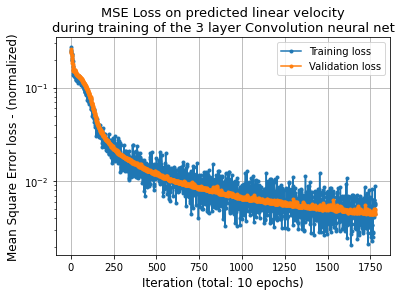

In [53]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted linear velocity\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("Iteration (total: 10 epochs)", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()